## 5%検定をしたときの3つの検定の比較

2つの二項分布をデータ生成モデルとした状況において，Pearsonの$\chi^2$検定，$\frac{n-1}{n}$補正の$\chi^2$検定，表の生起確率に基づくmid-p版Fisher「正確」検定で，名目的な有意水準を5%として検定したとき，実質的な有意水準がどれぐらいになるかを求めてみました．
各プロットは，各群の標本サイズ(n1, n2)において，X軸に二項分布の確率$\pi$を，Y軸に実質的な有意水準をプロットしたものです．


***履歴***
- 2020/1/1 06:53 乱数から有意／非有意を判定するループをmap関数に変更
- 2020/1/1 09:21 乱数シミュレーションを止めて数え上げで求めるように変更（大幅な変更）
- 2020/1/1 14:28 mid-pの計算部分を，map, filter, reduceを用いるように変更
- 2020/1/1 22:20 二項分布の確率ごとの計算を，forループからmap関数に変更

In [1]:
#バージョンの表示
versioninfo()

Julia Version 1.3.1
Commit 2d5741174c (2019-12-30 21:36 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i3-5005U CPU @ 2.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, broadwell)


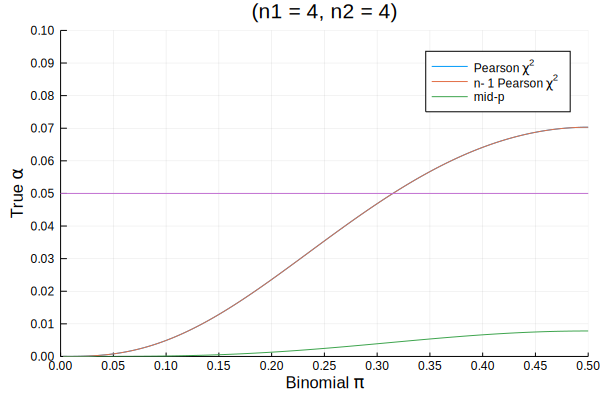

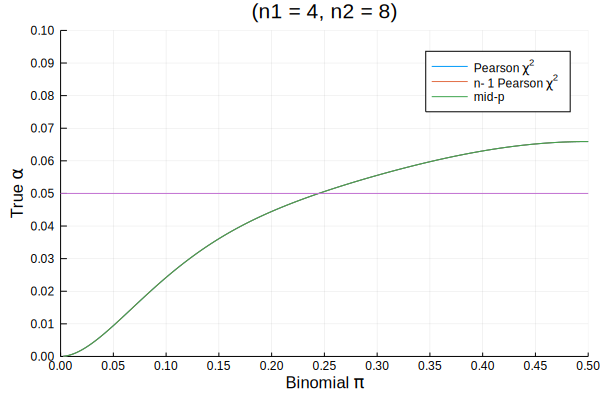

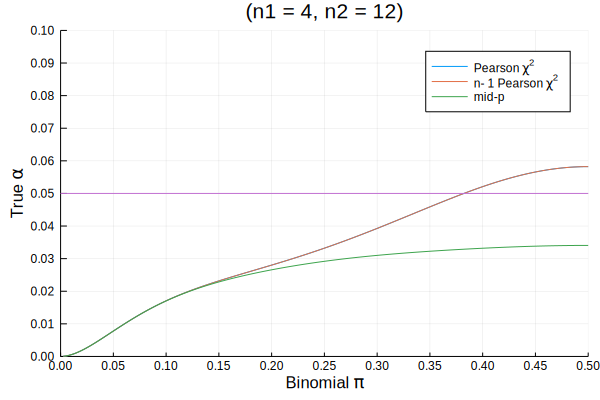

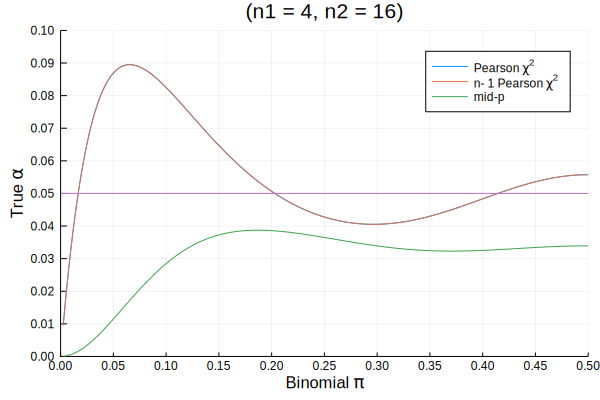

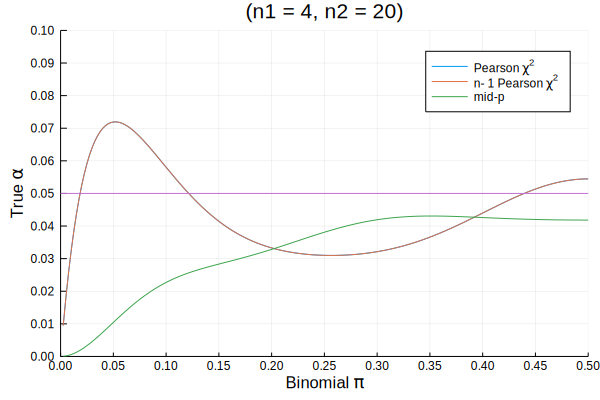

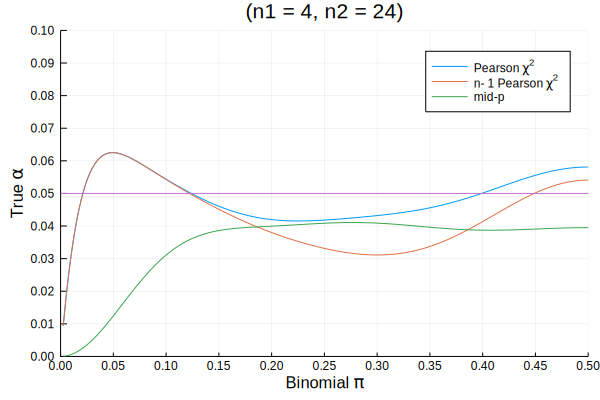

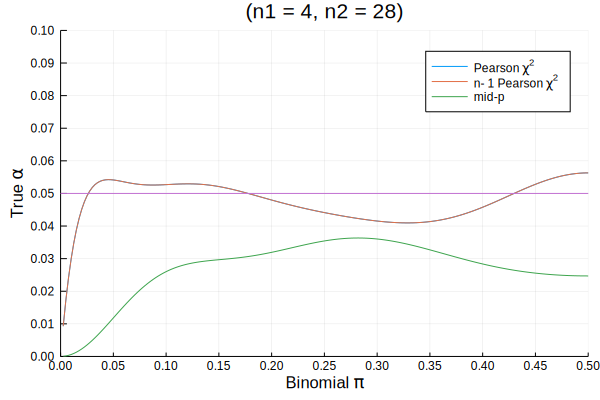

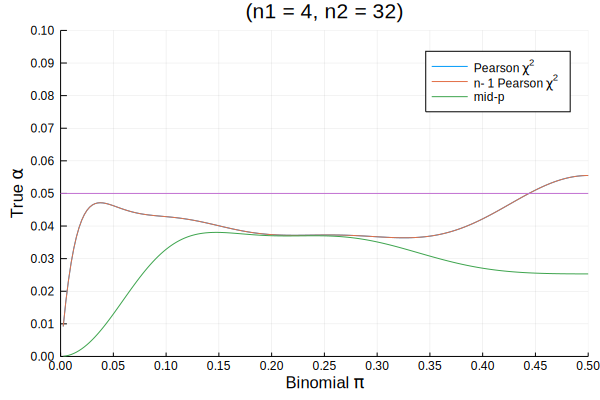

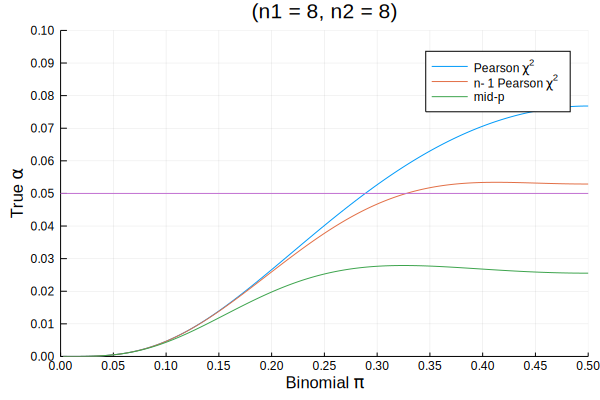

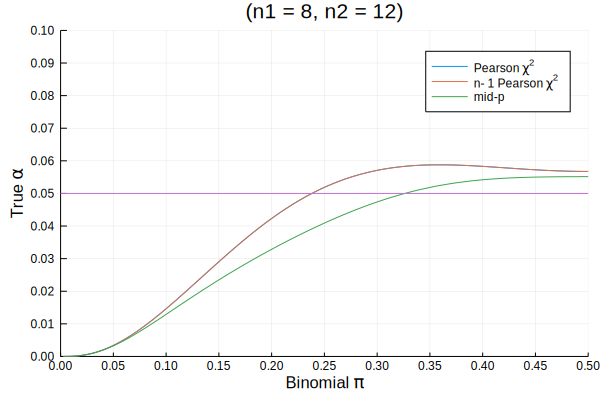

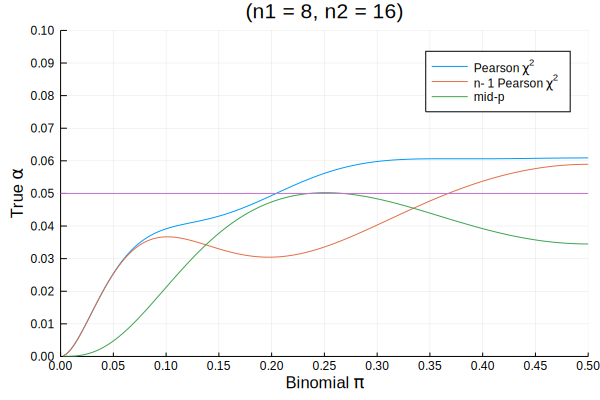

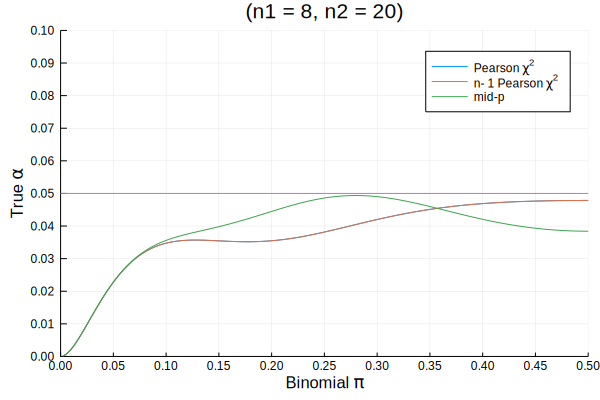

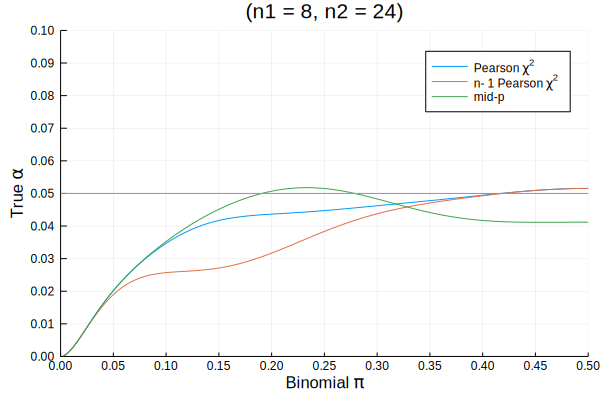

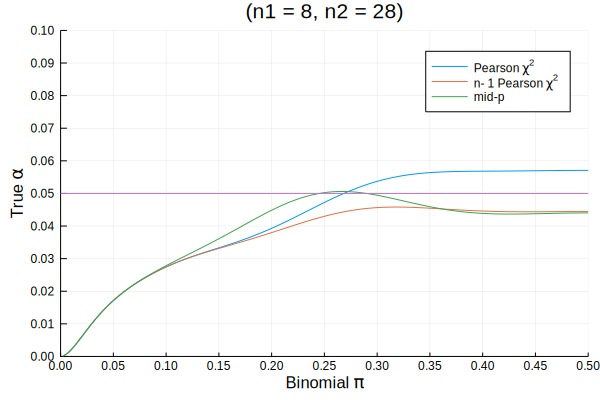

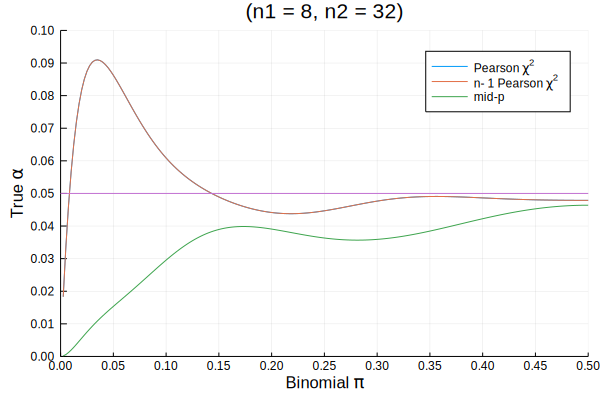

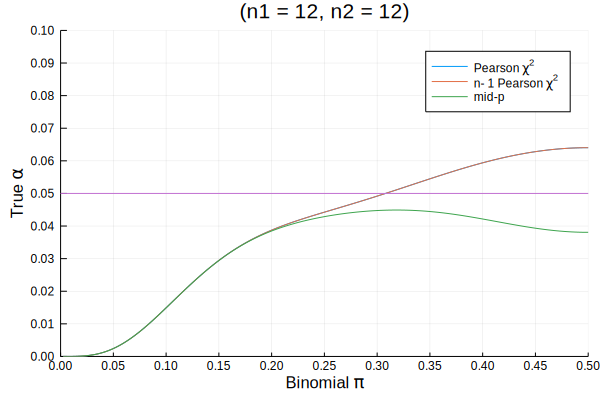

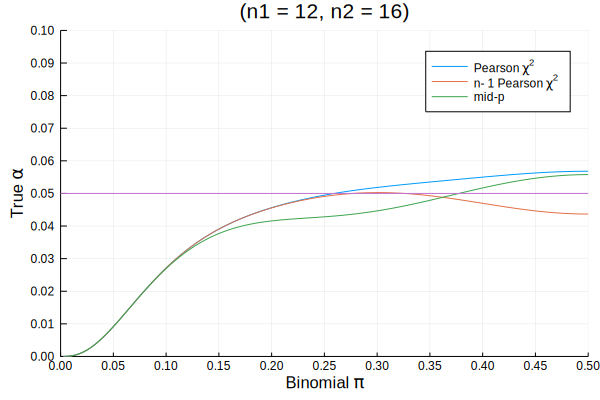

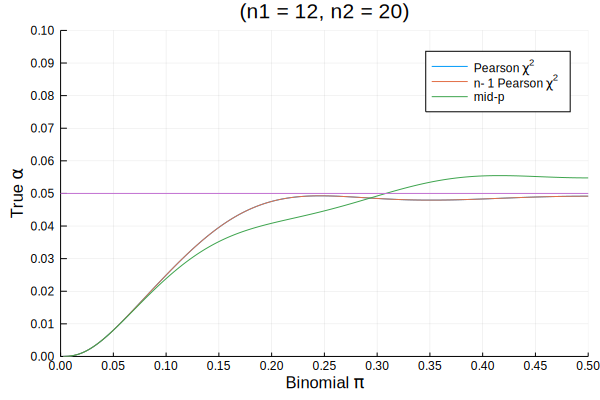

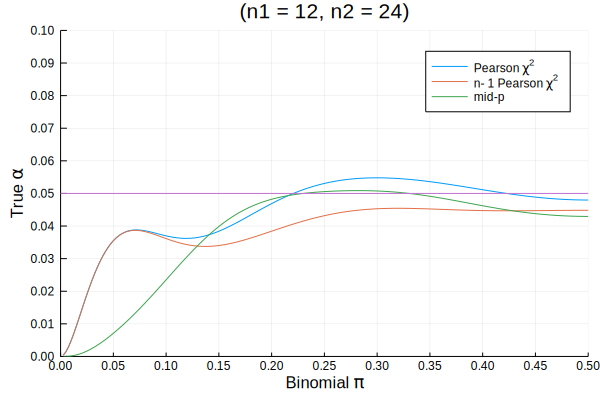

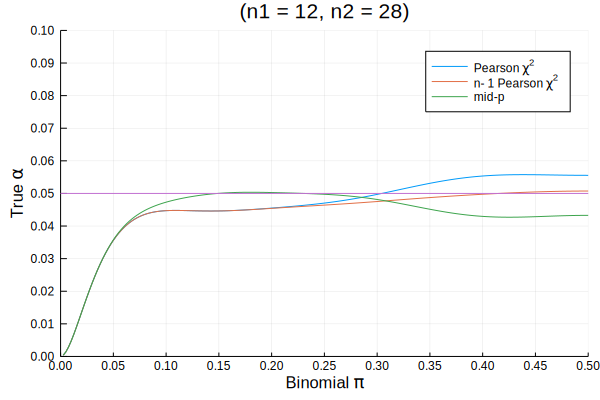

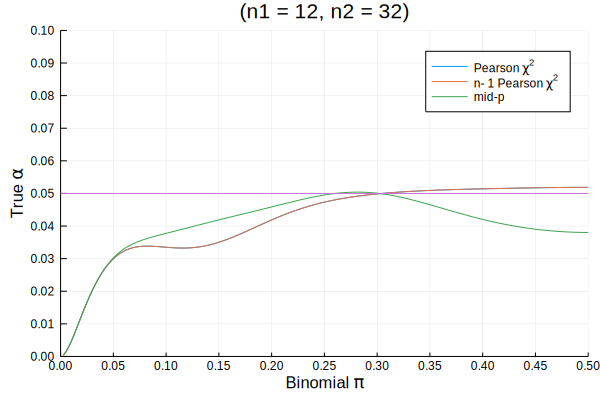

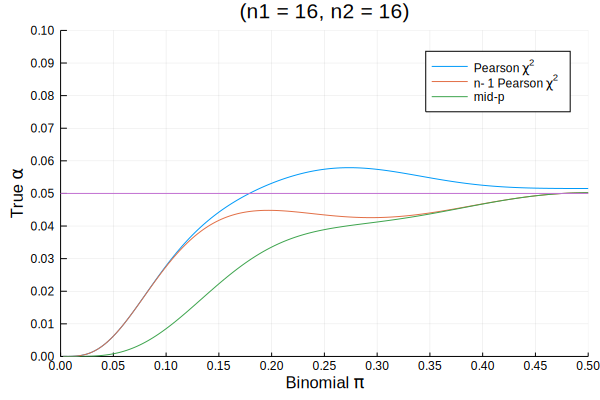

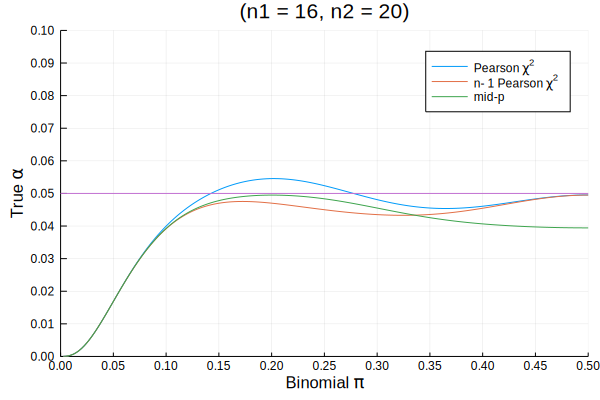

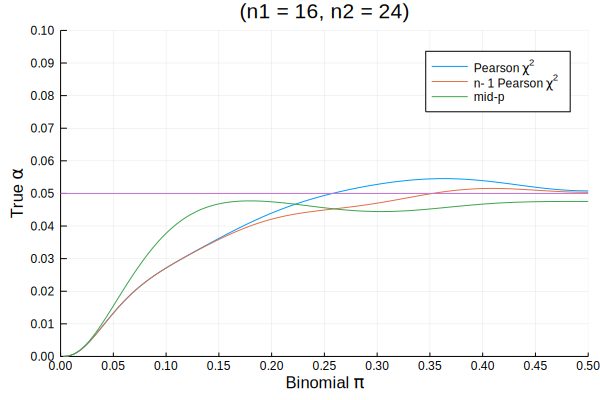

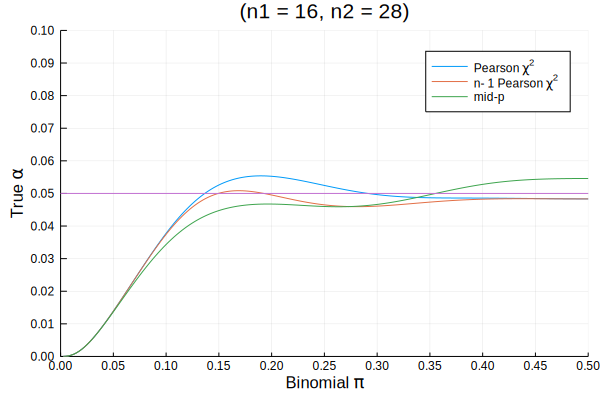

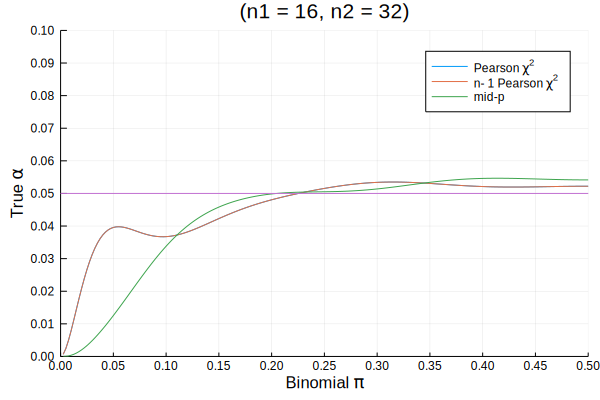

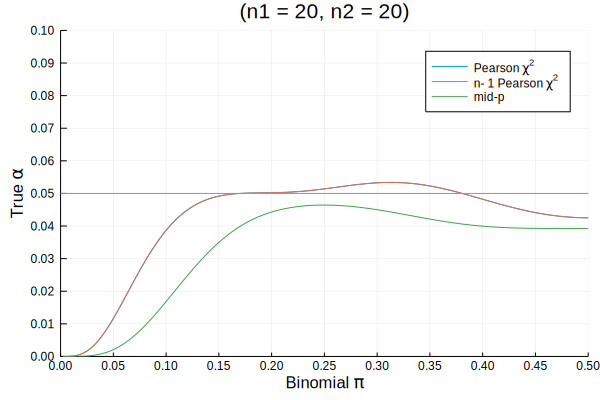

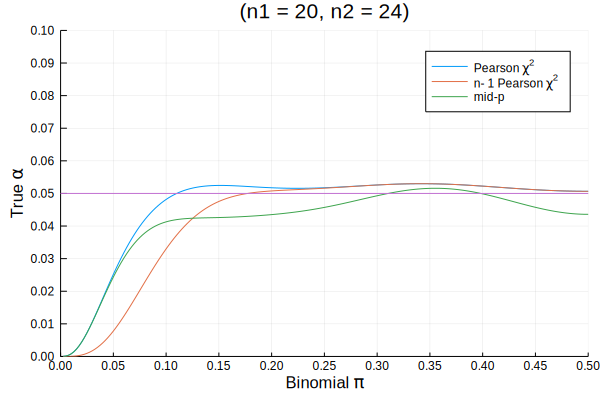

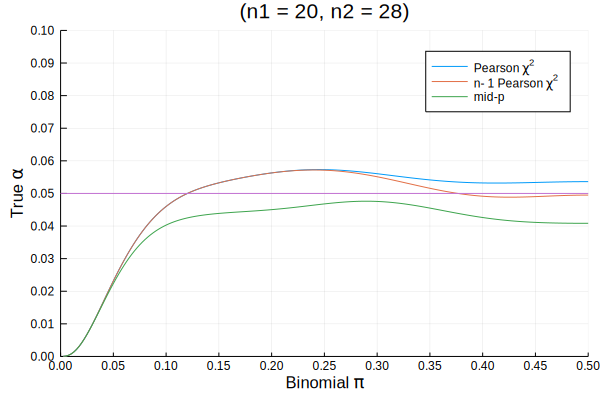

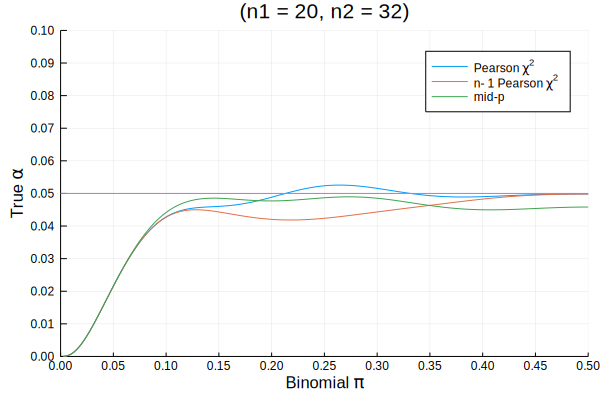

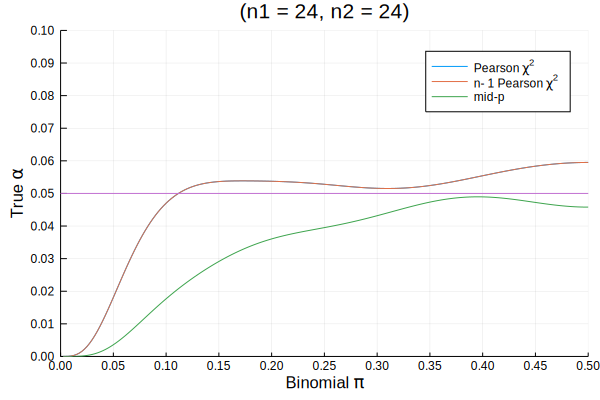

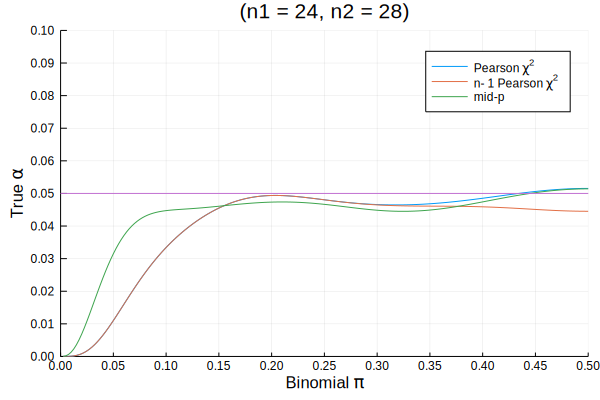

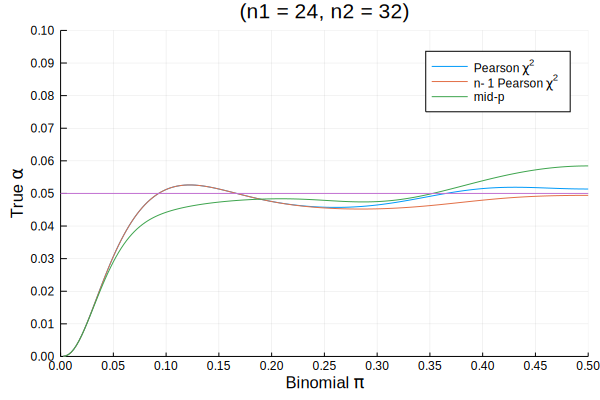

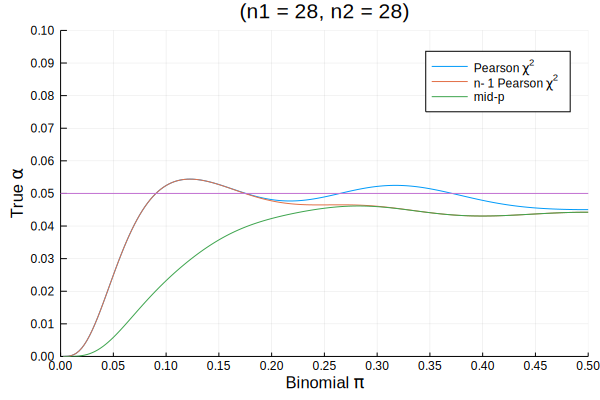

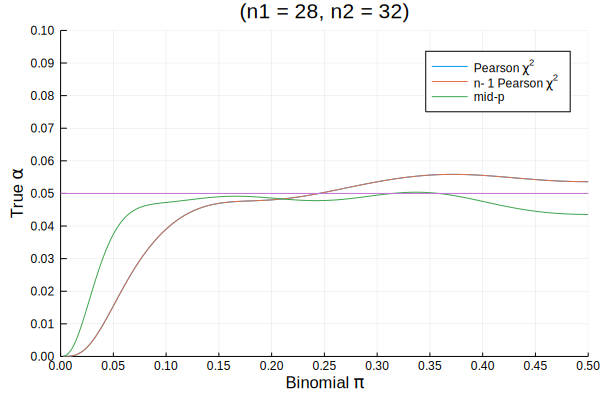

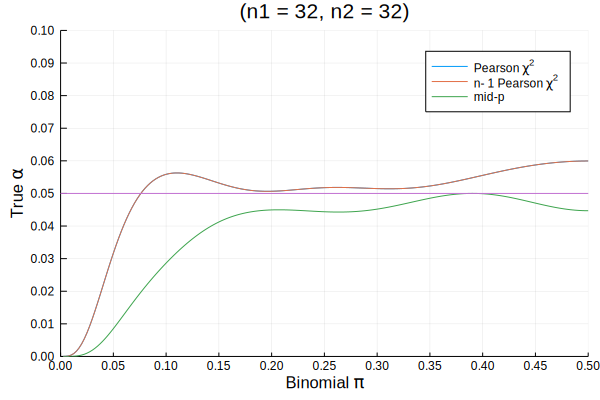

In [8]:
using Distributions, Plots

function calc_prob_when_significant(y1, y2, n1, n2, dist_bin1, dist_bin2, sig, q) 
    p1 = y1 / n1; p2 = y2 / n2
    n = n1 + n2; y = y1 + y2; p = y / n
    
    # 現在の表が生じる確率
    prob_bin = pdf(dist_bin1, y1) * pdf(dist_bin2, y2)
    
    # χ2乗の計算
    chisq = ifelse(p == 0 || p == 1, 0,  (p1 - p2)^2  / ((1/n1 + 1/n2) * p * (1-p)))
    
    p_chisq = ifelse(chisq >= q, prob_bin, 0)
    p_n_1_chisq =  ifelse((n - 1) * chisq / n >= q, prob_bin, 0)
    
    # mid-p の計算
    dist_hyp = Hypergeometric(n1, n2, y)
    prob_now = pdf(dist_hyp, y1)
    p_hyp = map((x)-> pdf(dist_hyp, x), 0:min(n1, y))
    temp1 = 0.5 * reduce(+, filter(x -> isapprox(x, prob_now), p_hyp))
    temp2 = reduce(+, filter(x -> (!isapprox(x, prob_now)) & (x < prob_now), p_hyp))
    midp = temp1 + temp2
    p_midp = ifelse(midp <= sig, prob_bin, 0)
    
    return [p_chisq, p_n_1_chisq, p_midp]
end


sig = 0.05
q = quantile.(Chisq(1), 1 - sig)

n = [4, 8, 12, 16, 20, 24, 28, 32]     # 群の標本サイズ
length_n = length(n) 

# 自由度1の95%分位点（5%の棄却域下限）
sig = 0.05
q = quantile.(Chisq(1), 1 - sig)

p = plot()
a_pi = [k / 400 for k in 1:200]
for (i, j) in [(i, j) for i in 1:length_n for j in i:length_n]
        prob = map((pi)-> 
                reduce(+, [calc_prob_when_significant(y1, y2, n[i], n[j],  Binomial(n[i], pi), Binomial(n[j], pi), sig, q) 
                    for y1 in 0:n[i] for y2 in 0:n[j]]),
                    a_pi)
                            
        p = plot(a_pi, map((x)->x[1], prob), title="(n1 = $(n[i]), n2 = $(n[j]))", label="Pearson \\chi^2",
                xaxis = ("Binomial \\pi", (0.00, 0.50), 0:0.05:0.5), 
                yaxis = ("True \\alpha", (0.00, 0.10), 0:0.01:0.10),
                size = (600, 400))
        plot!(p, a_pi, map((x)->x[2], prob), label="n-1 Pearson \\chi^2")
        plot!(p, a_pi, map((x)->x[3], prob), label="mid-p")
        plot!([0.05], seriestype = :hline, label="")
        
        display(p)
end     
